Notebook showing the failure of current methods in creating tables when columns should be merged. This is followed by a solution using this repository's package.

In [1]:
!pip install boto3
!pip install amazon-textract-caller
!pip install amazon-textract-prettyprinter
!pip install textract-trp 

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
import os, sys
import json
import boto3
from textractcaller import call_textract, Textract_Features
import pandas as pd
from PIL import Image

In [3]:
session = boto3.Session()

In [4]:
documentName = 'example-table-with-merged-cols.png'

In [5]:
image = Image.open(documentName)

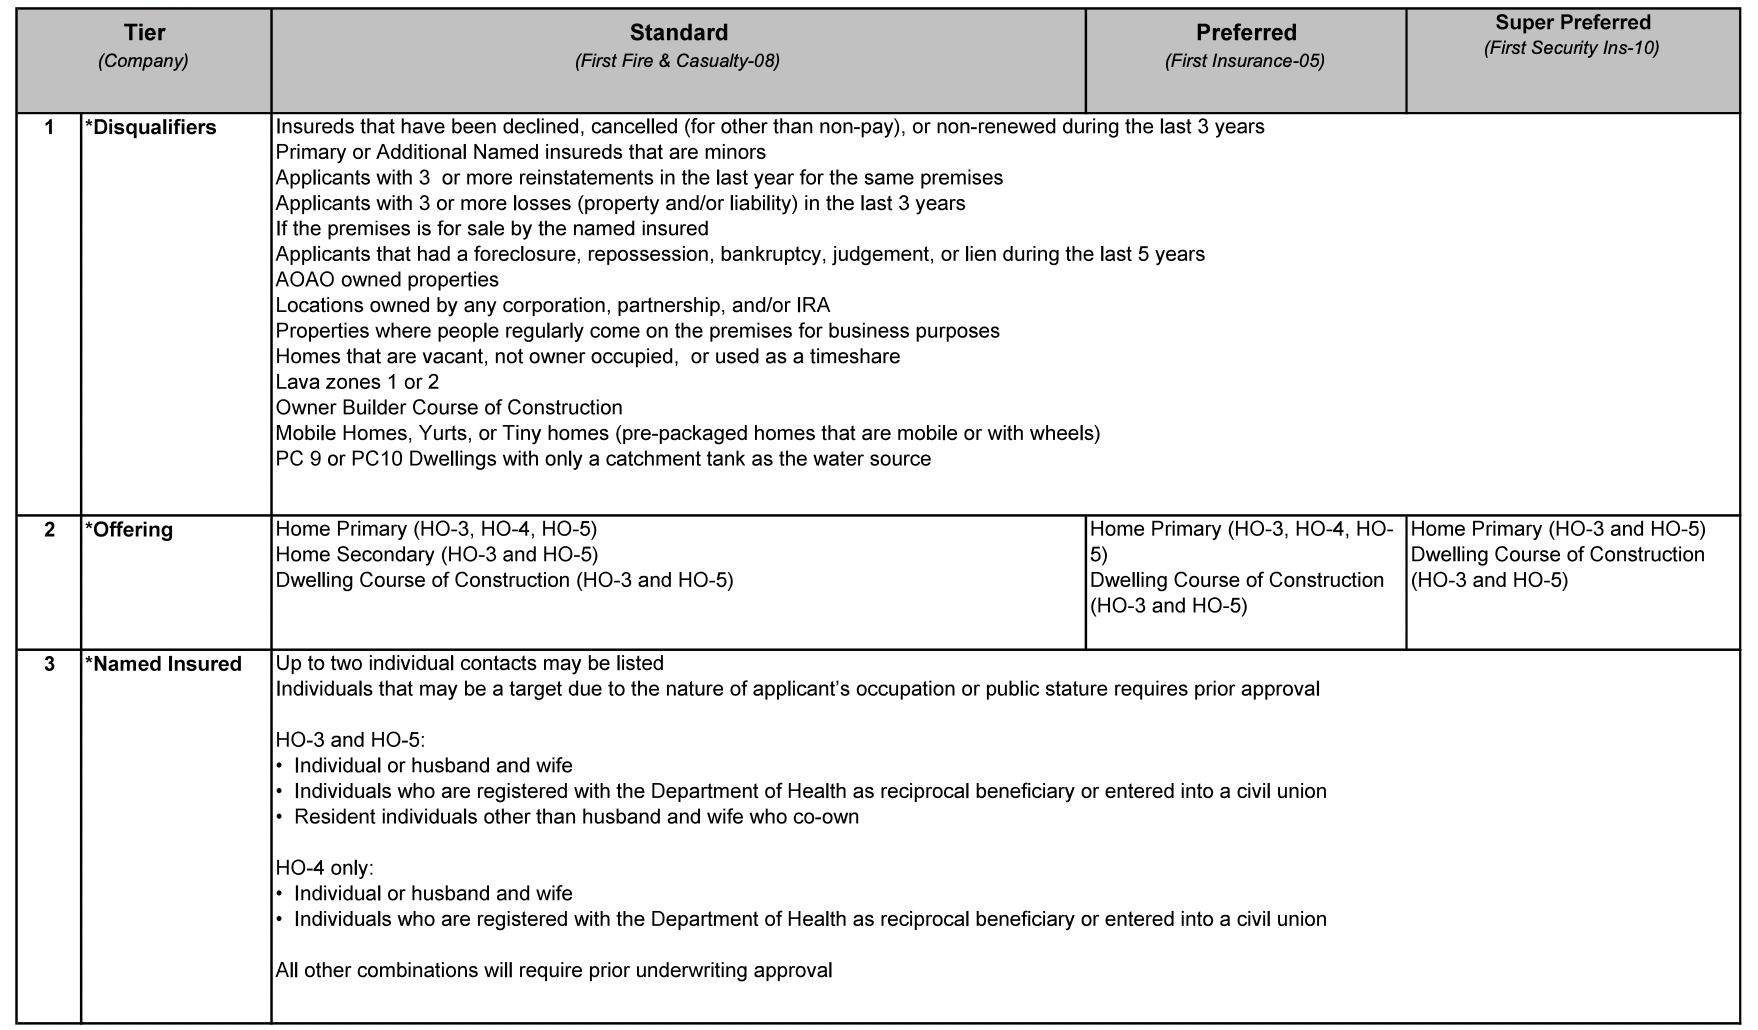

In [6]:
image

In [7]:
textract_json = call_textract(input_document=documentName, features = [Textract_Features.TABLES])

# Current methods using `textractprettyprinter` or `extract-trp`

In [8]:
from textractprettyprinter.t_pretty_print import Pretty_Print_Table_Format, Textract_Pretty_Print, get_string

In [9]:
print(get_string(textract_json=textract_json, output_type=[Textract_Pretty_Print.TABLES]))

|---|----------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------|--------------

You can see that in the row with index 1, the content `during the last 3 years last 5 years` appears in its own column instead of being part of content in the previous column as in the image.

Let's see the problem again by creating a Pandas dataframe instead using `extraxct-trp`.

In [10]:
from trp import Document
from textractprettyprinter.t_pretty_print import convert_table_to_list

In [11]:
tdoc = Document(textract_json)
dfs = list()

# The loop will look for all pages and all tables in each of the pages in case document is a multi-page PDF file
for page in tdoc.pages:
    for table in page.tables:
        dfs.append(pd.DataFrame(convert_table_to_list(trp_table=table)))

In [12]:
dfs[0]

,0,1,2,3,4
0,,Tier (Company),Standard (First Fire & Casualty-08),Preferred (First Insurance-05),Super Preferred (First Security Ins-10)
1,1,*Disqualifiers,"Insureds that have been declined, cancelled (f...",during the last 3 years last 5 years,
2,2,*Offering,"Home Primary (HO-3, HO-4, HO-5) Home Secondary...","Home Primary (HO-3, HO-4, HO- 5) Dwelling Cour...",Home Primary (HO-3 and HO-5) Dwelling Course o...
3,3,*Named Insured,Up to two individual contacts may be listed In...,requires prior approval or entered into a civi...,


Again the content in columns index 2 and 3 on row index 1 should be combined correctly. Right now, it is what you get if you cut artificially text given where they are located compared to the (invisible) vertical borders of each column. Because `during the last 3 years` and `last 5 years` appear under the third column (see original image), they are put in the third column even if it does not make sense (`during the last 3 years last 5 years` is nonsense) and should have been combined with the content from the second column. Also, the then-correct content under column 2 should be repeated in column 3 and 4 in line with the intent of how information is presented in the original image.

To correct for this, we read the content of the `LINE` objects from the `json` file, identify in which cells they should appear, and we use them (instead of the content of the `CELL` objects) to fill up the dataframe. In a second step, we identify which columns should be merged and we replace the content in each of the column that needs to be merged with the concatenated content from each column (all contents are considered as strings). Let's see how the example is treated.

# Method using `textract_json_to_df`

In [13]:
sys.path.append('textract_json_to_df')

In [14]:
import from_textract_json_to_df

In [15]:
tables = from_textract_json_to_df.build_df(textract_json)

In [16]:
len(tables)

1

In [17]:
table = tables[list(tables.keys())[0]]

In [18]:
table

,Tier\n(Company),Tier\n(Company),Standard\n(First Fire & Casualty-08),Preferred\n(First Insurance-05),Super Preferred\n(First Security Ins-10)
1,1,*Disqualifiers,"Insureds that have been declined, cancelled (f...","Insureds that have been declined, cancelled (f...","Insureds that have been declined, cancelled (f..."
2,2,*Offering,"Home Primary (HO-3, HO-4, HO-5)\nHome Secondar...","Home Primary (HO-3, HO-4, HO-\n5)\nDwelling Co...",Home Primary (HO-3 and HO-5)\nDwelling Course ...
3,3,*Named Insured,Up to two individual contacts may be listed\nI...,Up to two individual contacts may be listed\nI...,Up to two individual contacts may be listed\nI...


In [19]:
table.loc[1, table.columns[2]]

'Insureds that have been declined, cancelled (for other than non-pay), or non-renewed during the last 3 years\nPrimary or Additional Named insureds that are minors\nApplicants with 3 or more reinstatements in the last year for the same premises\nApplicants with 3 or more losses (property and/or liability) in the last 3 years\nIf the premises is for sale by the named insured\nApplicants that had a foreclosure, repossession, bankruptcy, judgement, or lien during the last 5 years\nAOAO owned properties\nLocations owned by any corporation, partnership, and/or IRA\nProperties where people regularly come on the premises for business purposes\nHomes that are vacant, not owner occupied, or used as a timeshare\nLava zones 1 or 2\nOwner Builder Course of Construction\nMobile Homes, Yurts, or Tiny homes (pre-packaged homes that are mobile or with wheels)\nPC 9 or PC10 Dwellings with only a catchment tank as the water source'

In [20]:
table.loc[1, table.columns[3]]

'Insureds that have been declined, cancelled (for other than non-pay), or non-renewed during the last 3 years\nPrimary or Additional Named insureds that are minors\nApplicants with 3 or more reinstatements in the last year for the same premises\nApplicants with 3 or more losses (property and/or liability) in the last 3 years\nIf the premises is for sale by the named insured\nApplicants that had a foreclosure, repossession, bankruptcy, judgement, or lien during the last 5 years\nAOAO owned properties\nLocations owned by any corporation, partnership, and/or IRA\nProperties where people regularly come on the premises for business purposes\nHomes that are vacant, not owner occupied, or used as a timeshare\nLava zones 1 or 2\nOwner Builder Course of Construction\nMobile Homes, Yurts, or Tiny homes (pre-packaged homes that are mobile or with wheels)\nPC 9 or PC10 Dwellings with only a catchment tank as the water source'

We can see that (1) the content of the two cells are the same because the two columns are merged and (2) the content also makes sense with `in the last 3 years` and `last 5 years` appearing in the right locations within the text, in accord with the original image.

Note also that we separate each content (each content is from a `LINE` object) by a newline symnbol `\n`. A trained NLP model or LLM could then be used to replace the newline symbol by either a period followed by a blank space (if indeed, it is a new sentence) or a blank space (if the sentence continues) but this is beyond the scope of this package.